# Assignment 4: Application of Neural Networks for Image Processing

In this assignment, you will complete three main tasks to deepen your understanding of neural networks, specifically using Convolutional Neural Networks (CNNs) for image processing:

1. **Image Classification with CNN (30 points)**  
   Create an image classifier using PyTorch, building and training a CNN model to classify images accurately.

2. **Image Denoising with CNN (45 points)**  
   Develop a denoising model using PyTorch, leveraging a CNN to remove noise from images and enhance visual quality.

3. **Kaggle Competition (25 + 20 points)**  
   Participate in a Kaggle competition where you will apply your skills in image classification on a challenging dataset.

In [67]:
%%capture
!uv pip install torch torchvision numpy matplotlib scipy tqdm safetensors

In [68]:
# Importing necessary libraries

import os
from datetime import datetime

import torch  # Core PyTorch library for tensor operations
import torch.nn as nn  # Neural network components
import torch.optim as optim  # Optimization algorithms
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting|
from torchvision import datasets, transforms  # Datasets and transformations for computer vision
from torch.utils.data import DataLoader, Dataset, random_split, Subset  # Data handling utilities
from tqdm import tqdm
from safetensors.torch import save_model, load_model

# SVHN Dataset

In this assignment, you will work with the **Street View House Numbers (SVHN) dataset** to develop a denoising algorithm and a classification task. The SVHN dataset consists of over **600,000** color images of house numbers collected from Google Street View images. Each image is a 32x32 pixel RGB image capturing digits (0-9) in real-world scenarios. The dataset can be found at [this link](http://ufldl.stanford.edu/housenumbers/).

For this assignment, you will use:

- **Training set**: 73,257 images
- **Testing set**: 26,032 images

In [69]:
# Define transformations for the dataset
transform = transforms.ToTensor()

# Load the training and test datasets
trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Set batch size as a parameter
batch_size = 64


# Function to create data loaders with a specified batch size
def get_dataloader(dataset, batch_size, shuffle):
  return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Create data loaders for training and testing
trainloader = get_dataloader(trainset, batch_size=batch_size, shuffle=True)
testloader = get_dataloader(testset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


# Visualization of SVHN dataset

In [70]:
# Define the class labels for the SVHN dataset
classes = [str(i) for i in range(10)]


# Function to display a grid of images with specified rows, columns, and class labels
def show_images_grid(dataloader, rows, cols):
  # Get a batch of training images and labels
  dataiter = iter(dataloader)
  images, labels = next(dataiter)

  fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
  idx = 0
  for i in range(rows):
    for j in range(cols):
      if idx < len(images):
        npimg = images[idx].numpy()
        axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[i, j].set_title(f'Class: {classes[labels[idx]]}')
        axes[i, j].axis('off')
        idx += 1
  plt.tight_layout()
  plt.show()

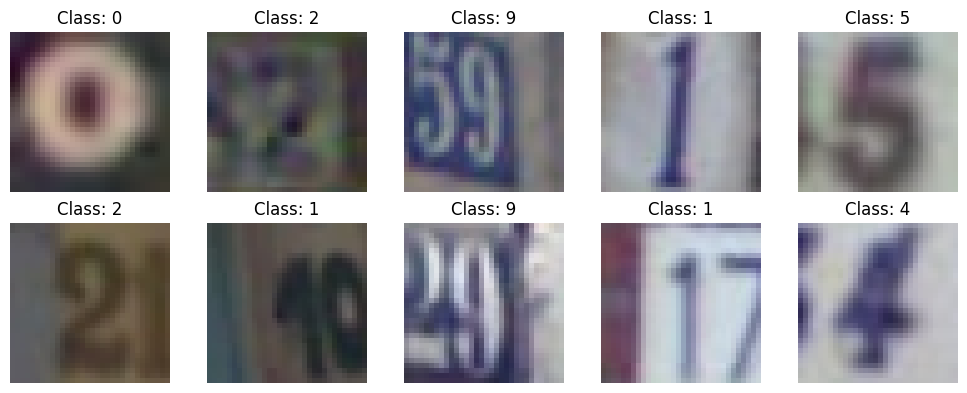

In [71]:
# Display a 2x5 grid of images from trainloader
show_images_grid(trainloader, rows=2, cols=5)

The `del` keyword deletes variables from memory, freeing up space. This is useful in large projects, especially deep learning, where datasets and data loaders use significant memory. Removing these variables ensures available memory for later code and helps avoid conflicts with similar names.


In [72]:
del trainset, testset, trainloader, testloader, transform, batch_size, get_dataloader

# <font color="red">Task 1: SVHN Image Classification Using a Convolutional Neural Network (CNN) (30 points) </font>

In this task, you will complete the implementation of a CNN model and use it to classify images from the SVHN dataset. Your goal is to build an accurate model that can recognize and classify house number digits in real-world images.


When available, a GPU can accelerate neural network training with parallel computations, ideal for large datasets and complex models.


In [73]:
# Set up device for training (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Hyper-Parameters:

In [74]:
batch_size = 64  # Batch size for data loading
learning_rate = 0.05  # Learning rate for optimizer
num_epochs = 20  # Number of training epochs
momentum = 0.9
weight_decay = 1e-4

Loading the dataset

In [75]:
# Define transformations for SVHN dataset
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
])

# Load training and test datasets with transformations
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Create data loaders with specified batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


## **A (15 points)** Build the CNN Model


A convolutional layer can be implemented in pytorch like

```
nn.Conv2d(in_channels=, out_channels=, kernel_size=, padding=, stride=).
```

Complete the CNN model implementation with the following architecture:

1. **Convolutional Layers**:
   - Three convolutional layers with:
     - `kernel_size=3`, `stride=1`, `padding=1`
     - Output channels:
       - First layer: 32 channels
       - Second layer: 64 channels
       - Third layer: 128 channels
   - Each convolutional layer is followed by:
     - Batch normalization to stabilize and speed up training
     - ReLU activation for non-linearity
     - Max pooling (`kernel_size=2`, `stride=2`) to reduce spatial dimensions

2. **Fully Connected Layers**:
   - Flatten the output from the convolutional layers.
   - First fully connected layer with 128 units and ReLU activation.
   - Final fully connected layer with 10 units for classification (one for each class in SVHN).

In [101]:
# utilities to serde with safetensors


def save_pretrained(model, name='model', *, base_path='./model'):
  os.makedirs(base_path, exist_ok=True)
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

  # Create filename with model name and timestamp
  filename = f'{name}_{timestamp}.safetensors'
  filepath = os.path.join(base_path, filename)

  # Save the model
  save_model(model, filepath)
  print(f'Model saved to {filepath}')
  return filepath

In [102]:
class PretrainedMixin:
  @classmethod
  def from_pretrained(cls, filepath, device='cuda'):
    model = cls().to(device)
    load_model(model, filepath)
    model.eval()
    return model

  def save_pretrained(self, base_path='./model'):
    save_pretrained(self, name=self.__class__.__qualname__, base_path=base_path)

In [103]:
class SVHNClassifier(nn.Module, PretrainedMixin):
  def __init__(self):
    super(SVHNClassifier, self).__init__()

    # not specified in spec, but add dropout for stability
    self.convblock1 = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.convblock2 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.convblock3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    # Calculate input size for the first fully connected layer
    # Input image: 32x32
    # After 3 max pooling layers (32 -> 16 -> 8 -> 4)
    # With 128 channels: 128 * 4 * 4 = 2048
    self.fc = nn.Sequential(nn.Linear(128 * 4 * 4, 128), nn.ReLU(), nn.Linear(128, 10))

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

## **B (15 points)** Train the network
In the part, we are going to train the SVHN_CNN model to classify SVHN dataset.

1. Finish implementing train and test functions.
2. Include last epoch results for train/test loss and train/test accuracy in your report
3. Plot the train/test losses and train/test accuracies using the plot_metrics function.


In [93]:
# Initialize model and move to device
model = SVHNClassifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropy includes softmax
if True:
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)
if False:
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [94]:
# Define function to evaluate model performance
def evaluate(model, data_loader, criterion, epoch, num_epochs, *, ncols=100):
  model.eval()  # Set model to evaluation mode
  total_loss = 0
  correct = 0
  total = 0

  with (
    torch.no_grad(),
    tqdm(data_loader, desc=f'eval  {epoch + 1}/{num_epochs}', ncols=ncols) as eval_data_loader,
  ):  # No gradient calculation for evaluation
    for data, targets in eval_data_loader:
      # Move data to device
      data = data.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = model(data)
      loss = criterion(outputs, targets)

      # Accumulate loss
      total_loss += loss.item() * data.size(0)

      # Calculate accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

  # Calculate average loss and accuracy
  avg_loss = total_loss / total
  accuracy = 100 * correct / total

  return accuracy, avg_loss

In [95]:
# Training the model
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# bar stuff
ncols = 100

for epoch in range(num_epochs):
  model.train()  # Set model to training mode
  running_loss = 0.0
  total = 0
  correct = 0

  # Training loop with tqdm progress bar
  with tqdm(
    enumerate(train_loader), total=len(train_loader), desc=f'epoch {epoch + 1}/{num_epochs}', ncols=ncols
  ) as batch_pbar:
    for i, (data, targets) in batch_pbar:
      # Move data to device
      data = data.to(device)
      targets = targets.to(device)

      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(data)
      loss = criterion(outputs, targets)

      # Backward pass and optimize
      loss.backward()
      optimizer.step()

      # Track training statistics
      running_loss += loss.item() * data.size(0)
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

      # Update batch progress bar
      batch_pbar.set_postfix({'batch_loss': loss.item()})

  # Calculate average training loss and accuracy for this epoch
  train_loss = running_loss / total
  train_accuracy = 100 * correct / total

  # Evaluate on train and test sets after each epoch
  test_accuracy, test_loss = evaluate(model, test_loader, criterion, epoch + 1, num_epochs, ncols=ncols)

  # Print epoch statistics
  print('-' * 60)
  print(f'epoch {epoch + 1:02d}/{num_epochs:02d} - Train Loss: {train_loss:.6f}, Train Acc: {train_accuracy:.2f}%')
  print(f'            - Test Loss: {test_loss:.6f}, Test Acc: {test_accuracy:.2f}%')
  print('-' * 60)

  # Store losses and accuracies
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

eval  2/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 114.90it/s]


------------------------------------------------------------
epoch 01/20 - Train Loss: 0.738209, Train Acc: 76.31%
            - Test Loss: 0.460860, Test Acc: 86.17%
------------------------------------------------------------


eval  3/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 112.73it/s]


------------------------------------------------------------
epoch 02/20 - Train Loss: 0.363855, Train Acc: 89.01%
            - Test Loss: 0.348315, Test Acc: 89.72%
------------------------------------------------------------


eval  4/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 114.52it/s]


------------------------------------------------------------
epoch 03/20 - Train Loss: 0.294560, Train Acc: 91.20%
            - Test Loss: 0.375101, Test Acc: 88.85%
------------------------------------------------------------


eval  5/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 114.35it/s]


------------------------------------------------------------
epoch 04/20 - Train Loss: 0.249752, Train Acc: 92.66%
            - Test Loss: 0.316894, Test Acc: 90.64%
------------------------------------------------------------


eval  6/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 112.55it/s]


------------------------------------------------------------
epoch 05/20 - Train Loss: 0.218510, Train Acc: 93.53%
            - Test Loss: 0.290605, Test Acc: 91.79%
------------------------------------------------------------


eval  7/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 113.38it/s]


------------------------------------------------------------
epoch 06/20 - Train Loss: 0.193034, Train Acc: 94.37%
            - Test Loss: 0.387319, Test Acc: 88.32%
------------------------------------------------------------


eval  8/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 112.97it/s]


------------------------------------------------------------
epoch 07/20 - Train Loss: 0.171169, Train Acc: 94.97%
            - Test Loss: 0.298162, Test Acc: 91.44%
------------------------------------------------------------


eval  9/20: 100%|████████████████████████████████████████████████| 407/407 [00:03<00:00, 111.44it/s]


------------------------------------------------------------
epoch 08/20 - Train Loss: 0.150749, Train Acc: 95.62%
            - Test Loss: 0.325905, Test Acc: 90.91%
------------------------------------------------------------


eval  10/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 115.42it/s]


------------------------------------------------------------
epoch 09/20 - Train Loss: 0.132484, Train Acc: 96.16%
            - Test Loss: 0.293228, Test Acc: 91.89%
------------------------------------------------------------


eval  11/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 115.97it/s]


------------------------------------------------------------
epoch 10/20 - Train Loss: 0.115858, Train Acc: 96.65%
            - Test Loss: 0.312531, Test Acc: 91.62%
------------------------------------------------------------


eval  12/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 114.73it/s]


------------------------------------------------------------
epoch 11/20 - Train Loss: 0.098826, Train Acc: 97.15%
            - Test Loss: 0.304291, Test Acc: 92.22%
------------------------------------------------------------


eval  13/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 114.80it/s]


------------------------------------------------------------
epoch 12/20 - Train Loss: 0.086760, Train Acc: 97.44%
            - Test Loss: 0.329752, Test Acc: 91.54%
------------------------------------------------------------


eval  14/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 115.73it/s]


------------------------------------------------------------
epoch 13/20 - Train Loss: 0.075698, Train Acc: 97.75%
            - Test Loss: 0.328805, Test Acc: 91.87%
------------------------------------------------------------


eval  15/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 113.70it/s]


------------------------------------------------------------
epoch 14/20 - Train Loss: 0.064567, Train Acc: 98.08%
            - Test Loss: 0.330988, Test Acc: 91.90%
------------------------------------------------------------


eval  16/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 114.75it/s]


------------------------------------------------------------
epoch 15/20 - Train Loss: 0.052779, Train Acc: 98.51%
            - Test Loss: 0.361344, Test Acc: 91.63%
------------------------------------------------------------


eval  17/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 116.03it/s]


------------------------------------------------------------
epoch 16/20 - Train Loss: 0.044054, Train Acc: 98.78%
            - Test Loss: 0.373459, Test Acc: 91.55%
------------------------------------------------------------


eval  18/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 116.14it/s]


------------------------------------------------------------
epoch 17/20 - Train Loss: 0.035443, Train Acc: 99.04%
            - Test Loss: 0.371599, Test Acc: 92.22%
------------------------------------------------------------


eval  19/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 111.15it/s]


------------------------------------------------------------
epoch 18/20 - Train Loss: 0.027670, Train Acc: 99.29%
            - Test Loss: 0.429213, Test Acc: 91.15%
------------------------------------------------------------


eval  20/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 113.56it/s]


------------------------------------------------------------
epoch 19/20 - Train Loss: 0.024244, Train Acc: 99.34%
            - Test Loss: 0.415622, Test Acc: 91.67%
------------------------------------------------------------


eval  21/20: 100%|███████████████████████████████████████████████| 407/407 [00:03<00:00, 113.90it/s]

------------------------------------------------------------
epoch 20/20 - Train Loss: 0.025504, Train Acc: 99.22%
            - Test Loss: 0.410858, Test Acc: 91.92%
------------------------------------------------------------


In [96]:
def plot_metrics(train_metrics, test_metrics, metric_name):
  plt.figure(figsize=(8, 6))
  epochs = np.arange(len(train_metrics))

  plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
  plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

  plt.xlabel('Epochs')
  plt.ylabel(metric_name)
  plt.title(f'{metric_name} over Epochs')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

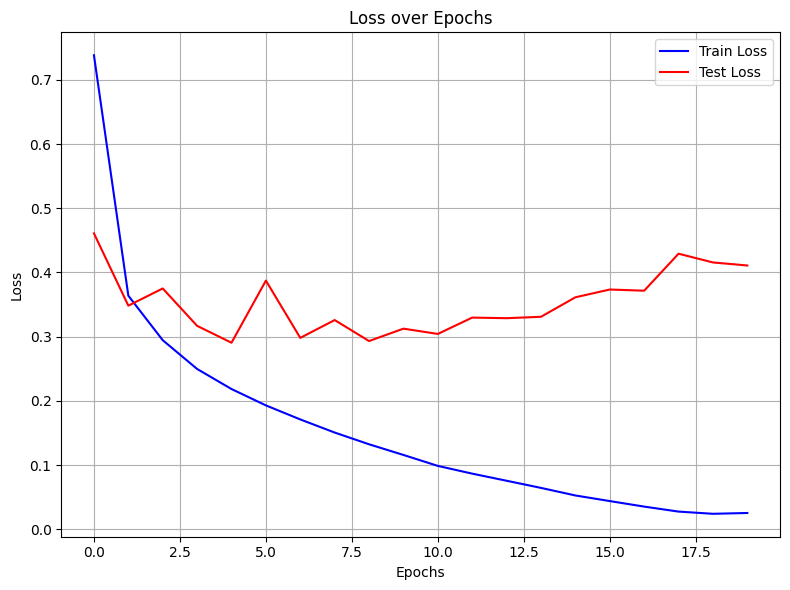

In [97]:
# Plot loss
plot_metrics(train_losses, test_losses, 'Loss')

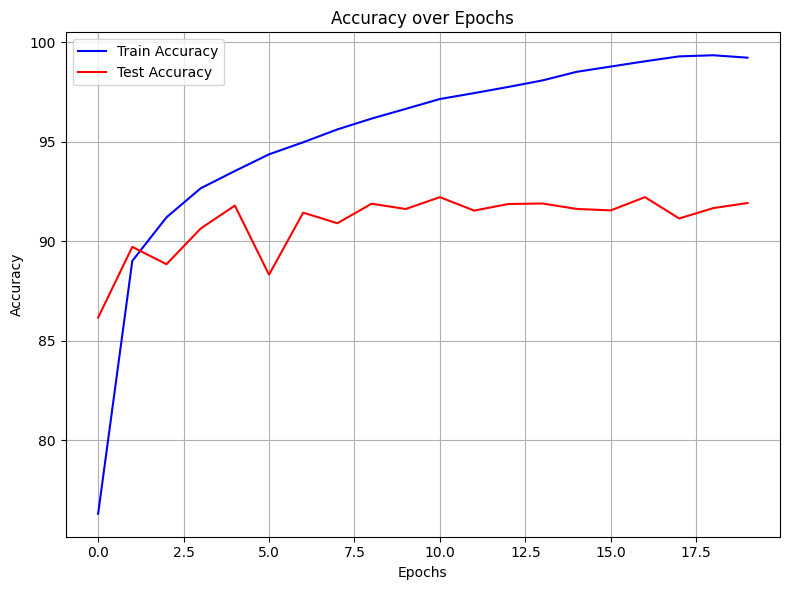

In [98]:
# Plot accuracy
plot_metrics(train_accuracies, test_accuracies, 'Accuracy')

In [99]:
if False:
  model.save_pretrained()

# <font color="red">Task 2: SVHN Denoising with Convolution Neural Network (CNN) (45 points) </font>
Convolutional Neural Network (CNN) have also been quite successful in the field of image processing. In this part, you are asked to finish the implementation of the CNN model and use the model to denoise images from SVHN.

The objective of tasks in the assignment is to train a network that, given a noisy image, recovers the original image. Therefore, each training point consists of the input (noisy image) and the expected output (true image).






Again, we remove these variables ensures available memory for later code and helps avoid conflicts with similar names.

In [55]:
del (
  device,
  batch_size,
  learning_rate,
  num_epochs,
  train_dataset,
  test_dataset,
  train_loader,
  test_loader,
  transform,
  SVHNClassifier,
  model,
  criterion,
  optimizer,
  evaluate,
  train_losses,
  test_losses,
  train_accuracies,
  test_accuracies,
  show_images_grid,
  classes,
)

In [56]:
# Set up device for training (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Create the Noisy dataset

### Step 1: Defining a Custom Noise Transformation
First, we define a custom transformation that applies noise to each image by randomly dropping pixels. This transformation will be used to generate a noisy version of every image in the dataset.

In [57]:
# Custom transformation to add noise by dropping pixels with a given probability for each channel independently
class AddNoiseTransform:
  def __init__(self, drop_prob=0.1):
    self.drop_prob = drop_prob

  def __call__(self, img):
    channel_mask = (torch.rand(img.shape) > self.drop_prob).float()
    noisy_img = img * channel_mask
    return noisy_img

### Step 2: Creating a Dataset of Paired Images: Original and Noisy
We define a dataset that pairs each original image with a corresponding noisy image. This dataset is structured so that each data sample includes both the clean image (as the label) and the noisified version (as the feature). We then create PyTorch dataloaders where each element contains a pair of original and noisy images.

In [58]:
# PairDataset class that returns a pair of images: (original, noisy)
class PairDataset(Dataset):
  def __init__(self, dataset_origin, dataset_noisy):
    assert len(dataset_origin) == len(dataset_noisy), 'Datasets must be of the same length'
    self.dataset_origin = dataset_origin
    self.dataset_noisy = dataset_noisy

  def __getitem__(self, index):
    clean_img, _ = self.dataset_origin[index]
    noisy_img, _ = self.dataset_noisy[index]
    return clean_img, noisy_img

  def __len__(self):
    return len(self.dataset_origin)

In [59]:
# Function to create paired dataset for specific classes
def create_paired_dataloader(classes, num_samples=1500, batch_size=64, drop_prob=0.5, split='train'):
  """
  Creates a DataLoader for a paired dataset with noisy and clean images from specified classes.

  Parameters:
  - classes (list): List of class labels to include (e.g., [0, 1, 2, 3, 4] or [5, 6, 7, 8, 9]).
  - num_samples (int): Number of samples to use from the filtered classes.
  - batch_size (int): Batch size for the DataLoader.
  - drop_prob (float): Drop probability for AddNoiseTransform.
  - split (str): Dataset split to load ('train' or 'test').

  Returns:
  - DataLoader: A DataLoader for the paired dataset.
  """

  # Define transformations
  transform_clean = transforms.ToTensor()
  transform_noisy = transforms.Compose([transforms.ToTensor(), AddNoiseTransform(drop_prob=drop_prob)])

  # Load the specified dataset split
  dataset_clean_full = datasets.SVHN(root='./data', split=split, download=True, transform=transform_clean)
  dataset_noisy_full = datasets.SVHN(root='./data', split=split, download=True, transform=transform_noisy)

  # Filter to include only samples with specified classes
  indices = [i for i, (_, label) in enumerate(dataset_clean_full) if label in classes]

  # Take only the first `num_samples` samples after filtering
  subset_indices = indices[:num_samples]

  # Create clean and noisy subsets
  dataset_clean = Subset(dataset_clean_full, subset_indices)
  dataset_noisy = Subset(dataset_noisy_full, subset_indices)

  # Create the paired dataset
  paired_dataset = PairDataset(dataset_clean, dataset_noisy)

  # DataLoader for paired dataset
  paired_dataloader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=True)

  return paired_dataloader

## **Task A (10 points): Implementing a CNN for Image Denoising**

In this task, you will implement a Convolutional Neural Network (CNN) to map noisy images to their original, clean versions. This architecture consists of two convolutional layers.

### **Architecture Details**

1. **First Convolutional Layer**
   - **Setup**: `kernel_size=3`, `padding=1`, `stride=1` to maintain image dimensions.
   - **Input**: 32x32x3 images.
   - **Output**: Feature maps of size 32x32x30.
   - **Activation**: Apply ReLU for non-linearity.

2. **Second Convolutional Layer**
   - **Setup**: Same kernel size, padding, and stride as above.
   - **Output**: 32x32x3 to match the original image dimensions.
   - **Activation**: Sigmoid to constrain values between 0 and 1.

3. **Hyperparameters**
   - `input_channels=3`, `output_channels=3`, `feature_maps=30`.

### **Implementation Requirements**

Using these guidelines, implement the CNN model in PyTorch with `torch.nn.Conv2d` for the layers, and `torch.nn.ReLU` and `torch.nn.Sigmoid` for activations.

In [107]:
class ImageDenoisingCNN(nn.Module, PretrainedMixin):
  def __init__(self):
    super(ImageDenoisingCNN, self).__init__()

    # First Convolutional Layer
    # Input: 32x32x3 -> Output: 32x32x30
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, padding=1, stride=1)
    self.relu = nn.ReLU()

    # Second Convolutional Layer
    # Input: 32x32x30 -> Output: 32x32x3
    self.conv2 = nn.Conv2d(in_channels=30, out_channels=3, kernel_size=3, padding=1, stride=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # First conv layer with ReLU
    x = self.conv1(x)
    x = self.relu(x)

    # Second conv layer with Sigmoid
    x = self.conv2(x)
    x = self.sigmoid(x)

    return x

To understand the model’s complexity, we can calculate the total number of trainable parameters in ImageDenoisingCNN. Each parameter contributes to the model's ability to learn patterns in the data.

In [110]:
model = ImageDenoisingCNN()

# Calculate and print the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of trainable parameters in ImageDenoisingCNN:', num_params)

Total number of trainable parameters in ImageDenoisingCNN: 1653


## **Task B (20 points)**: Denoising SVHN Images
This task involves building and evaluating a model that can remove noise from SVHN images in the first 5 classes (0 through 4). The model is trained and tested on a dataset of noisy images paired with their clean counterparts, using only 1,500 samples per class.

**Objectives**:
1. Complete the training function: This function should return the average training and test losses for each epoch.
2. Complete the testing function: This function should compute the average test loss across all batches.
3. Denoise SVHN Images: Train the model to denoise images from the first 5 classes.

Include the last epoch train/test values and last epoch sample images in your report.

In [111]:
# Display a single row of images with specified columns
def show_images_grid2(images, title, cols):
  fig, axes = plt.subplots(1, cols, figsize=(cols * 2, 2))
  if cols == 1:
    axes = [axes]

  for idx in range(cols):
    if idx < len(images):
      img = images[idx].numpy().transpose((1, 2, 0))
      axes[idx].imshow(img)
      axes[idx].set_title(title)
      axes[idx].axis('off')

  plt.tight_layout()
  plt.show()

In [117]:
def train(train_loader, test_loader, model, epochs, loss_function, optimizer, device='cuda'):
  """
  Train the model on the training dataset and evaluate it on the test dataset.
  """
  # Move model to the specified device
  model = model.to(device)
  train_loss_epochs = []
  test_loss_epochs = []

  for epoch in range(epochs):
    model.train()
    train_loss_batches = []

    # Use context manager for batch progress bar
    with tqdm(
      enumerate(train_loader), total=len(train_loader), desc=f'epoch {epoch + 1}/{epochs}', ncols=100
    ) as batch_pbar:
      for batch_idx, (clean_images, noisy_images) in batch_pbar:
        # Move data to device
        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        denoised_images = model(noisy_images)
        loss = loss_function(denoised_images, clean_images)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track batch loss
        train_loss_batches.append(loss.item())
        batch_pbar.set_postfix({'batch_loss': loss.item()})

        # Display sample results every 5 epochs, at the last batch
        if epoch % 5 == 0 and batch_idx == len(train_loader) - 1:
          show_images_grid2(clean_images[:5].detach().cpu(), title='Clean', cols=5)
          show_images_grid2(noisy_images[:5].detach().cpu(), title='Noisy', cols=5)
          show_images_grid2(denoised_images[:5].detach().cpu(), title='Denoised', cols=5)

    # Calculate average training loss for the epoch
    train_loss_epoch = np.mean(train_loss_batches)
    train_loss_epochs.append(train_loss_epoch)

    # Evaluate model on test set
    test_loss_epoch = evaluate(test_loader, model, loss_function, epoch + 1, num_epochs, device=device)
    test_loss_epochs.append(test_loss_epoch)

  return train_loss_epochs, test_loss_epochs

In [118]:
def evaluate(dataloader, model, loss_function, epoch, num_epochs, device='cuda'):
  """
  Evaluate the model on the test dataset and return the average loss.
  """
  model.eval()
  test_losses = []

  with torch.no_grad():
    with tqdm(dataloader, desc=f'eval  {epoch}/{num_epochs}', ncols=100) as eval_pbar:
      for clean_images, noisy_images in eval_pbar:
        # Move data to device
        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)

        # Forward pass
        denoised_images = model(noisy_images)
        loss = loss_function(denoised_images, clean_images)

        # Track batch loss
        test_losses.append(loss.item())

  return np.mean(test_losses)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Starting training...


epoch 1/100:  88%|███████████████████████████▏   | 21/24 [00:00<00:00, 67.47it/s, batch_loss=0.0138]

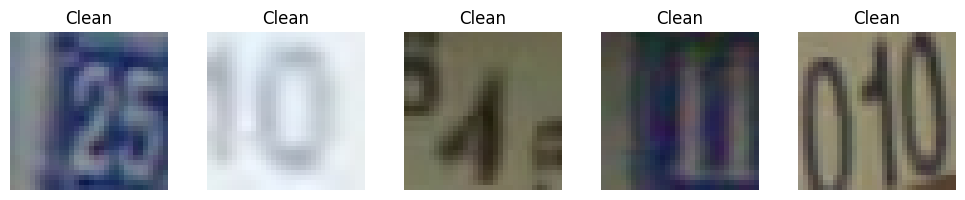

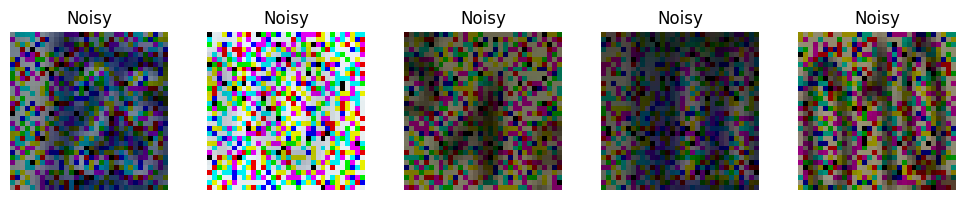

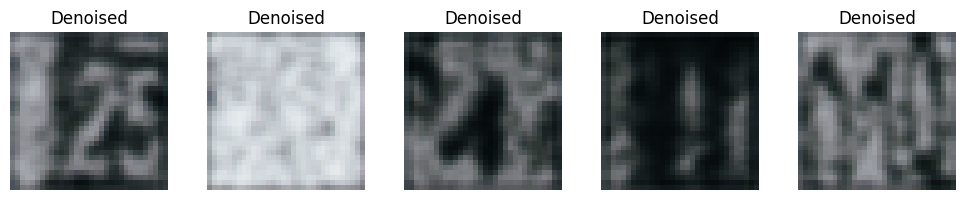

epoch 6/100:  88%|██████████████████████████▎   | 21/24 [00:00<00:00, 69.40it/s, batch_loss=0.00683]

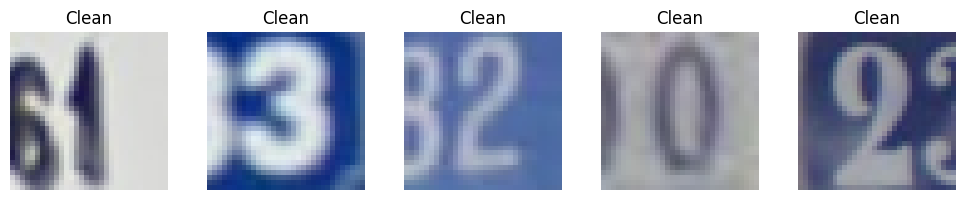

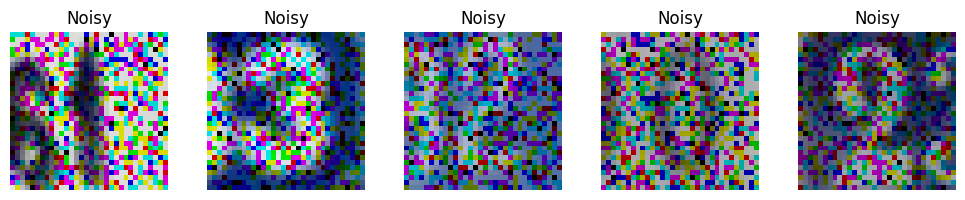

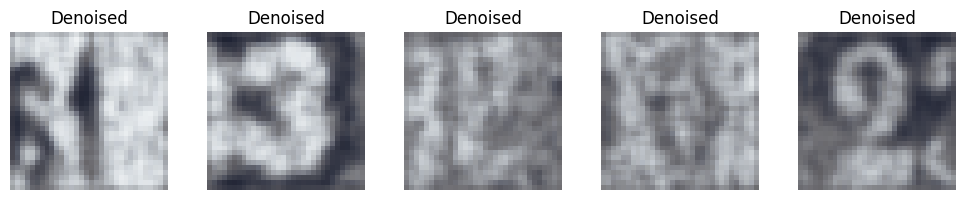

epoch 11/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 68.39it/s, batch_loss=0.00472]

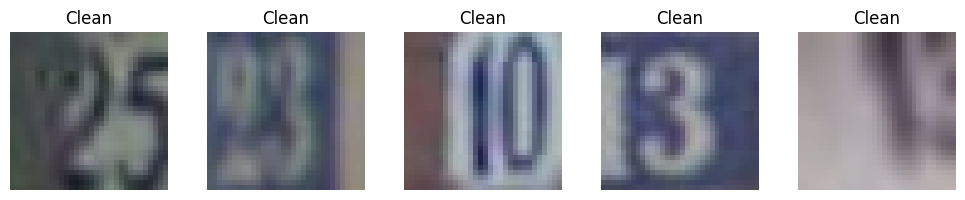

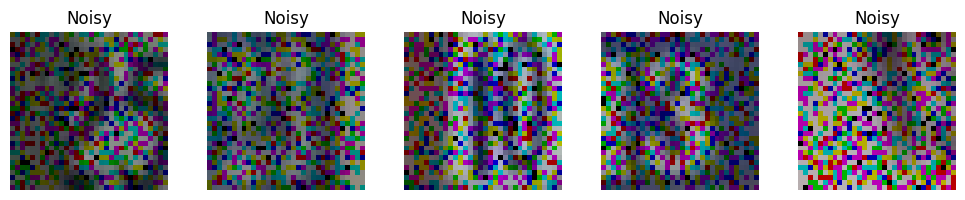

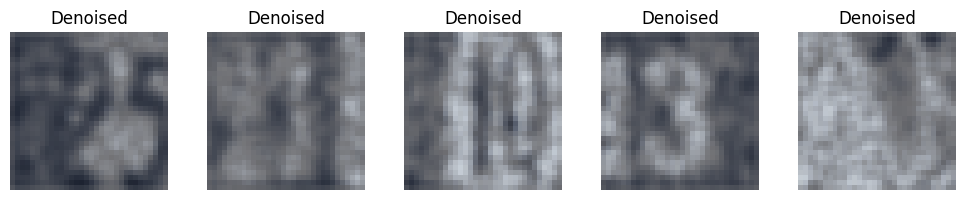

epoch 16/100:  92%|██████████████████████████▌  | 22/24 [00:00<00:00, 69.51it/s, batch_loss=0.00433]

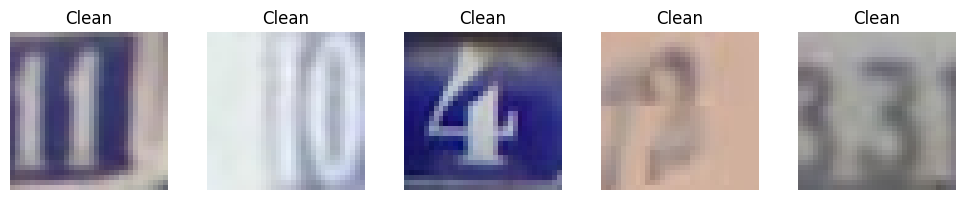

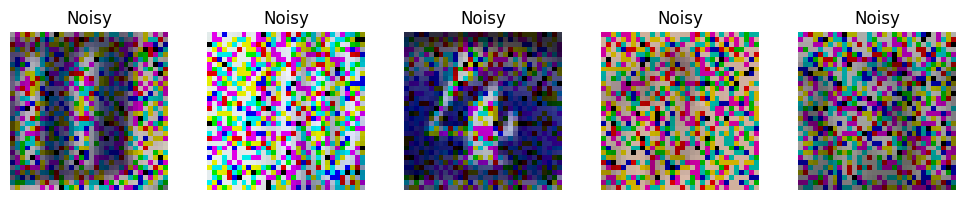

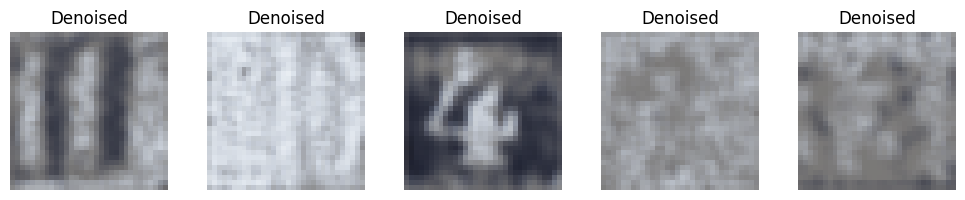

epoch 21/100:  67%|████████████████████          | 16/24 [00:00<00:00, 70.11it/s, batch_loss=0.0033]

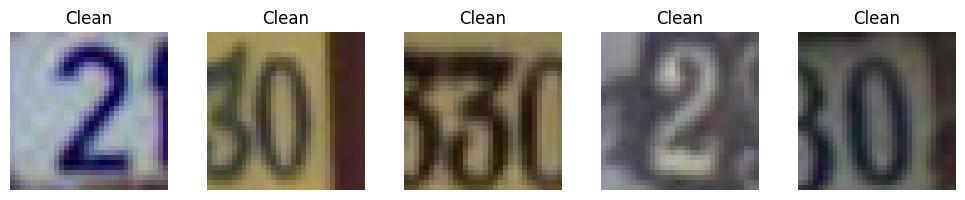

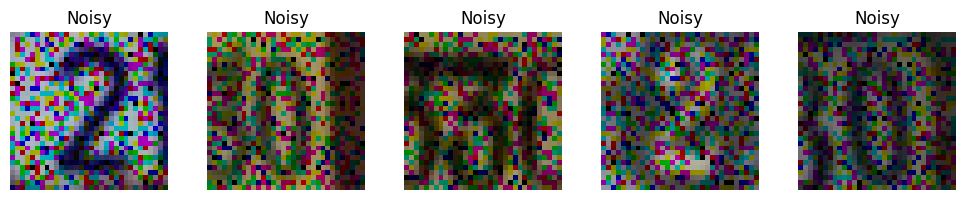

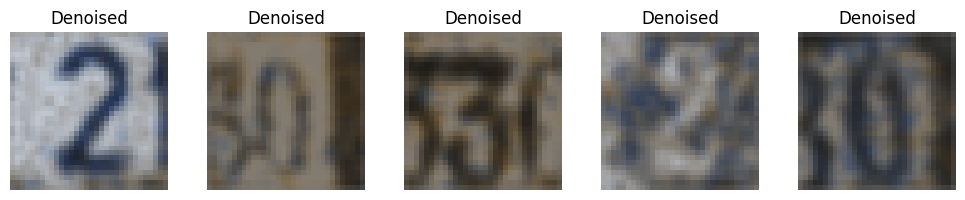

epoch 26/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 68.08it/s, batch_loss=0.00419]

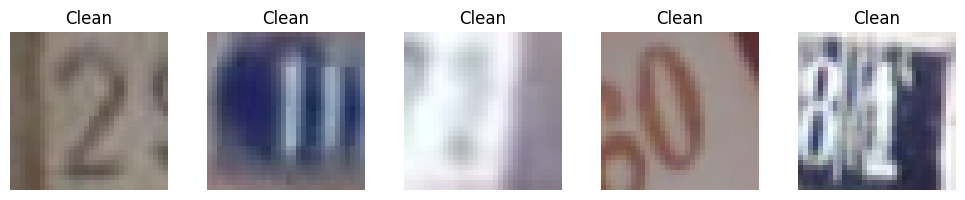

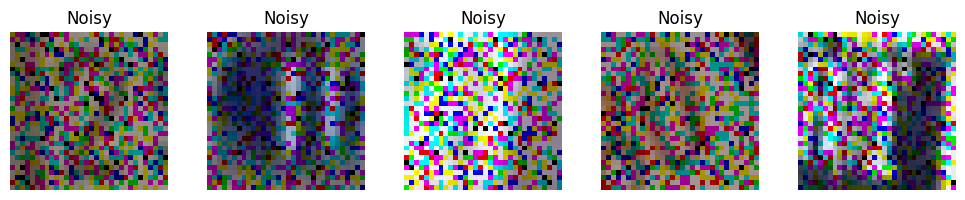

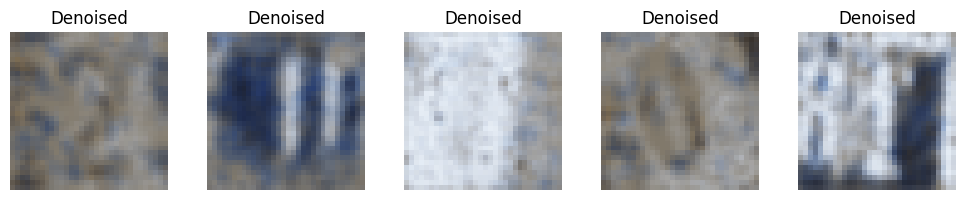

epoch 31/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 69.38it/s, batch_loss=0.00385]

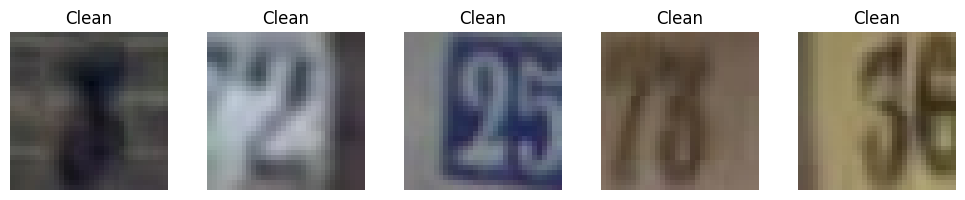

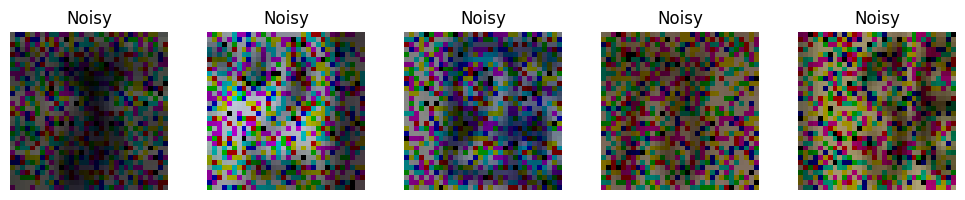

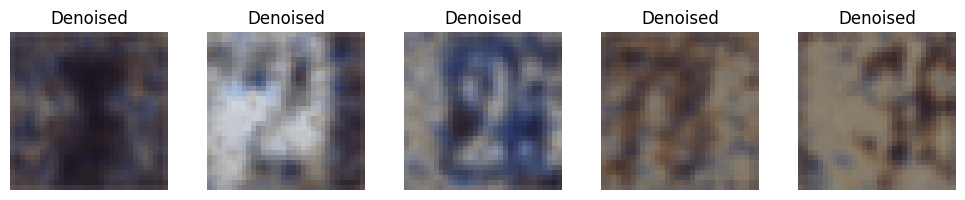

epoch 36/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 65.60it/s, batch_loss=0.00452]

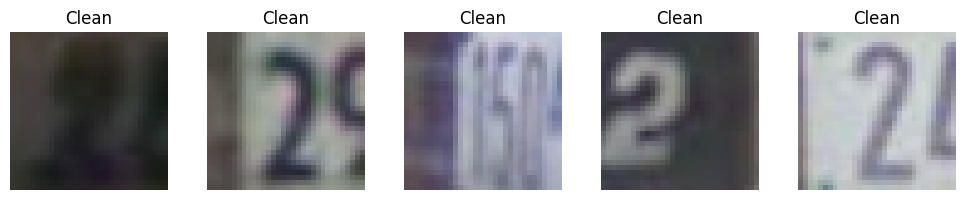

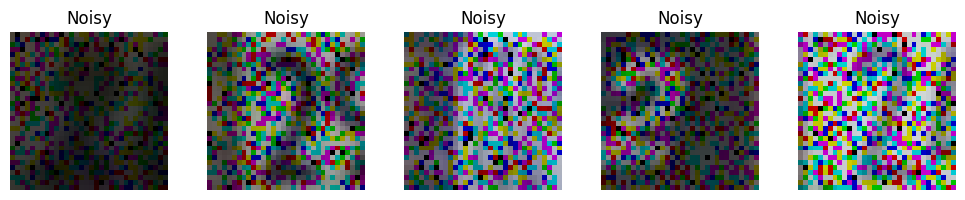

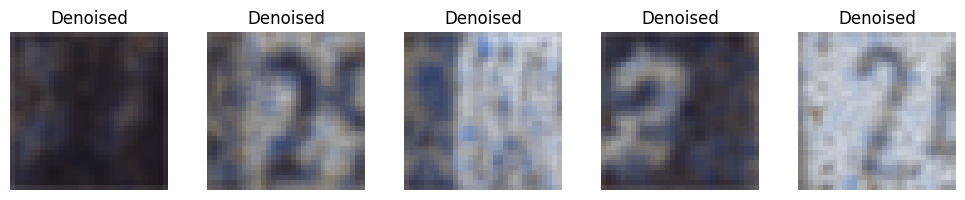

epoch 41/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 68.81it/s, batch_loss=0.00295]

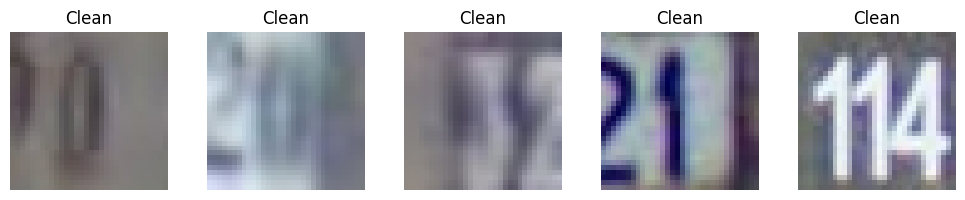

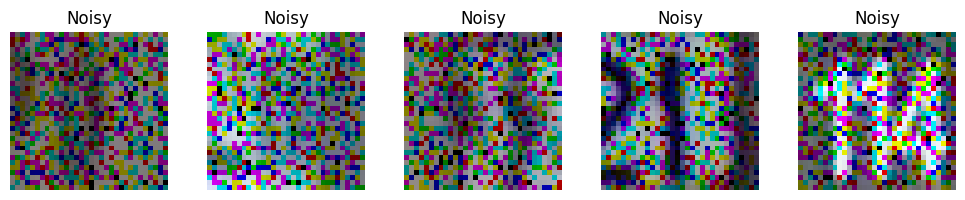

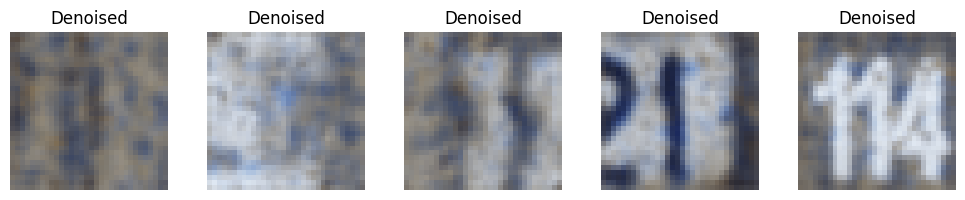

epoch 46/100:  67%|███████████████████▎         | 16/24 [00:00<00:00, 70.07it/s, batch_loss=0.00373]

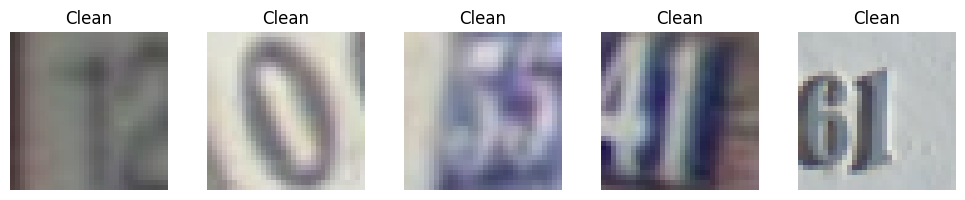

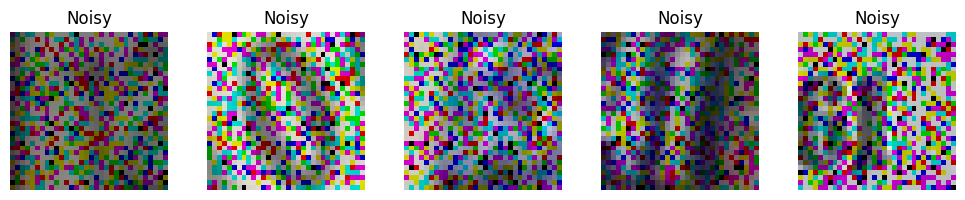

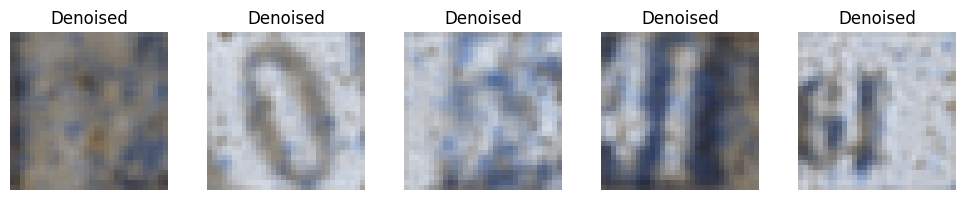

epoch 51/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 64.14it/s, batch_loss=0.00317]

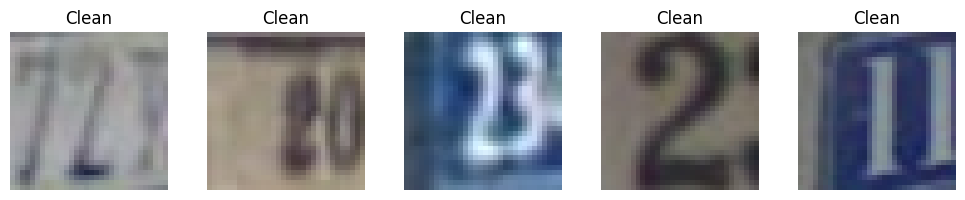

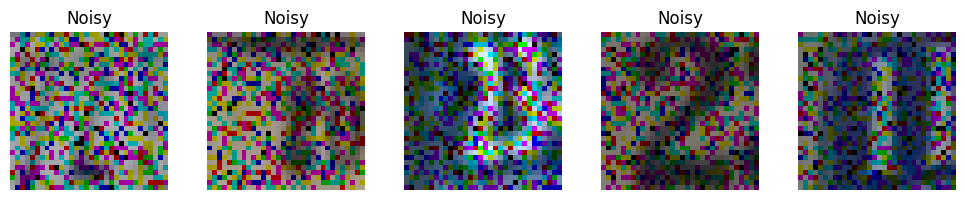

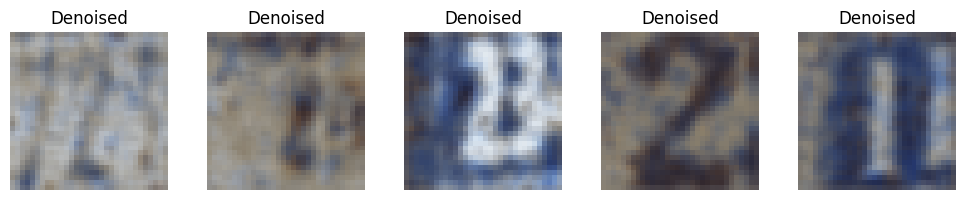

epoch 56/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 69.88it/s, batch_loss=0.00385]

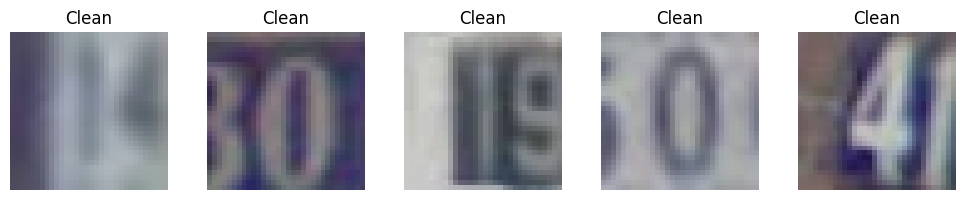

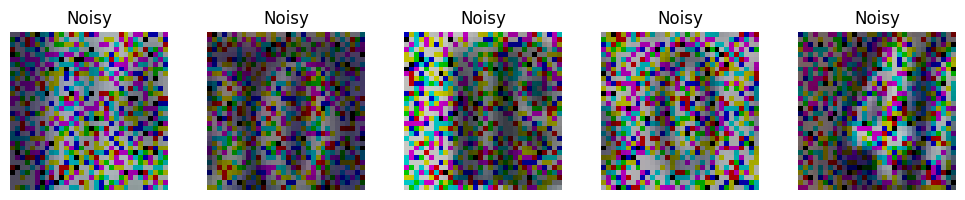

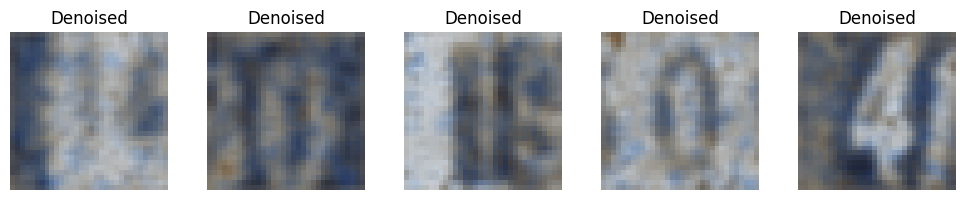

epoch 61/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 65.46it/s, batch_loss=0.00316]

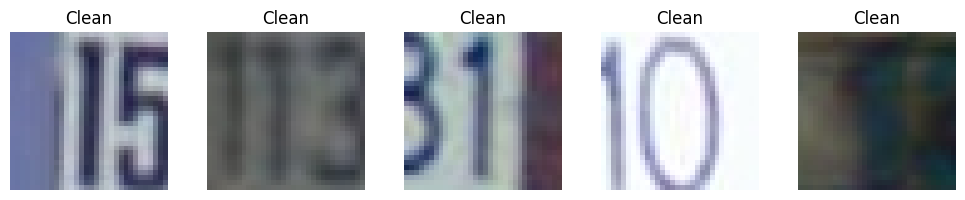

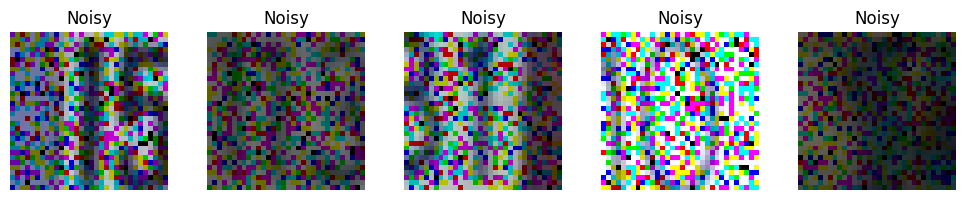

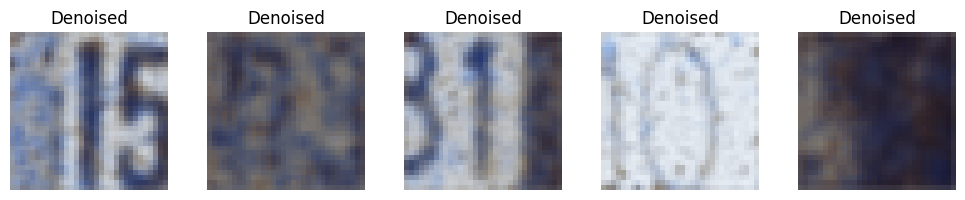

epoch 66/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 69.31it/s, batch_loss=0.00322]

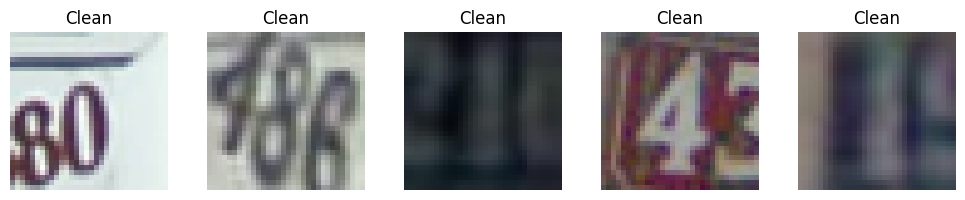

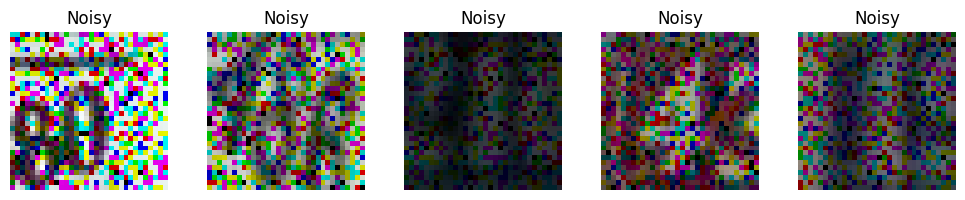

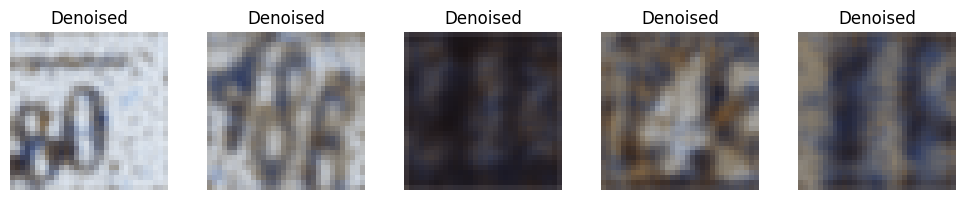

epoch 71/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 67.98it/s, batch_loss=0.00338]

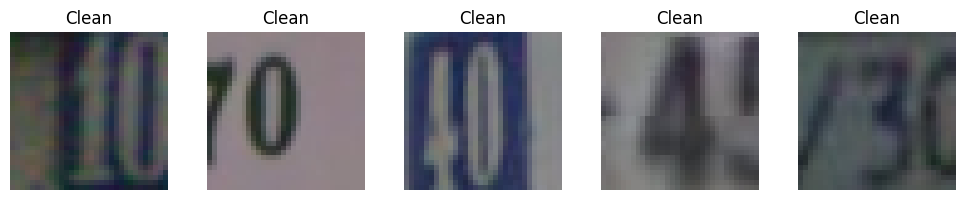

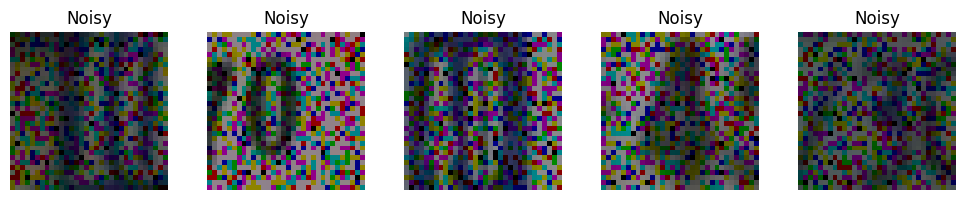

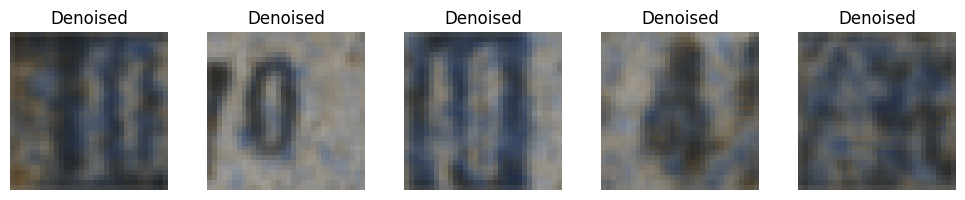

epoch 76/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 64.78it/s, batch_loss=0.00286]

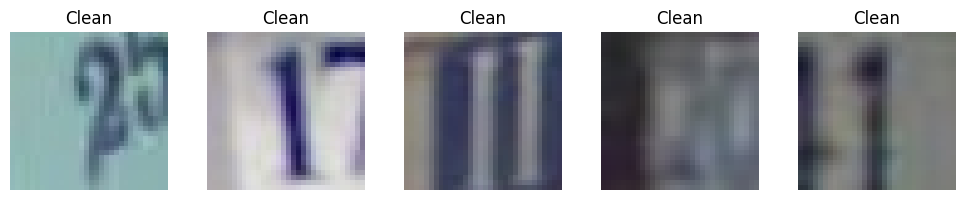

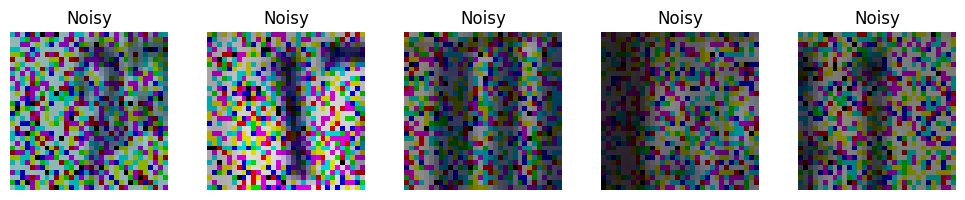

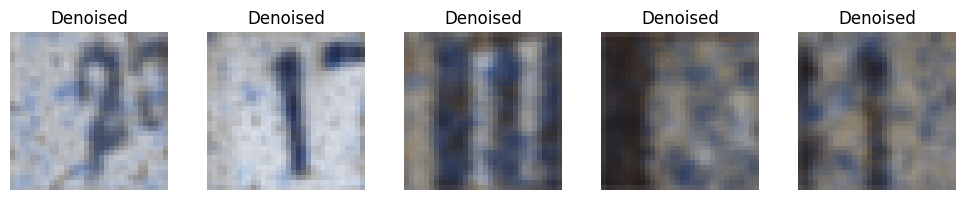

epoch 81/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 66.44it/s, batch_loss=0.00301]

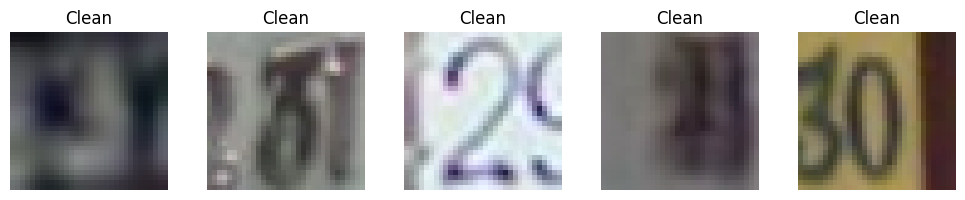

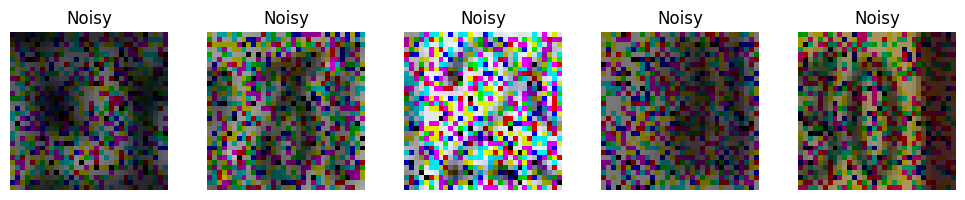

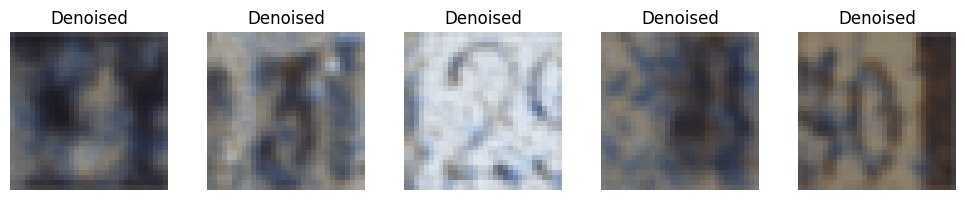

epoch 86/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 68.25it/s, batch_loss=0.00327]

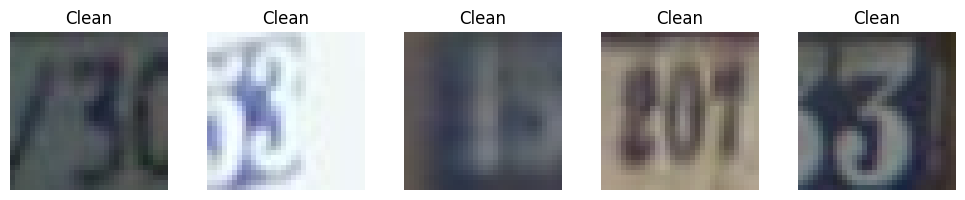

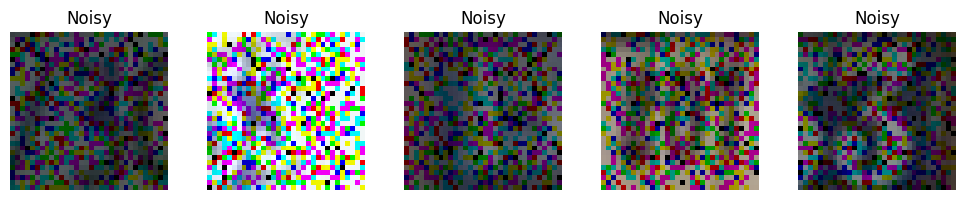

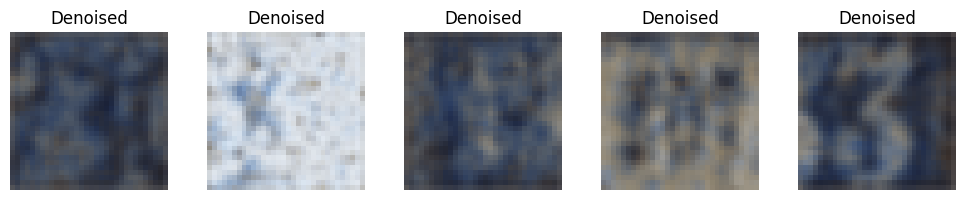

epoch 91/100:  88%|█████████████████████████▍   | 21/24 [00:00<00:00, 68.47it/s, batch_loss=0.00338]

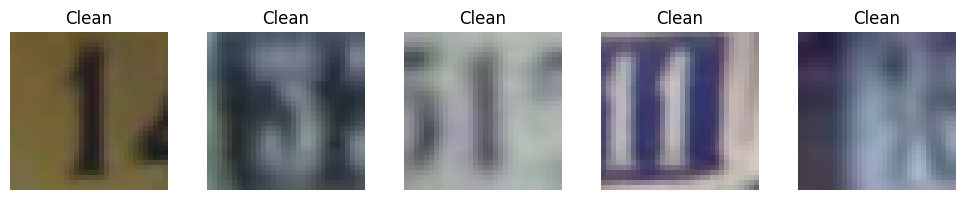

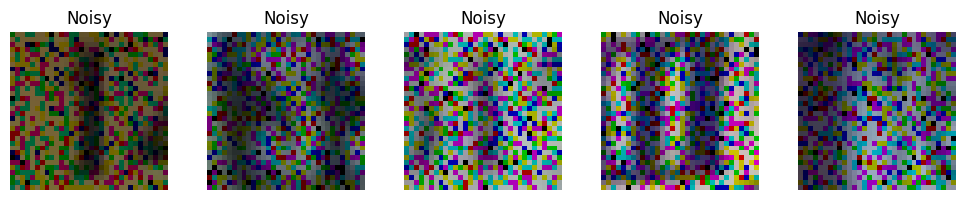

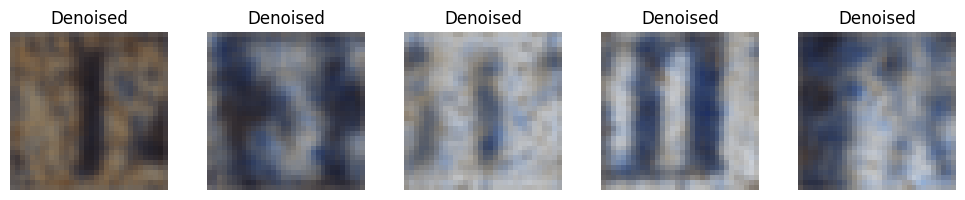

epoch 96/100:  92%|███████████████████████████▌  | 22/24 [00:00<00:00, 69.72it/s, batch_loss=0.0027]

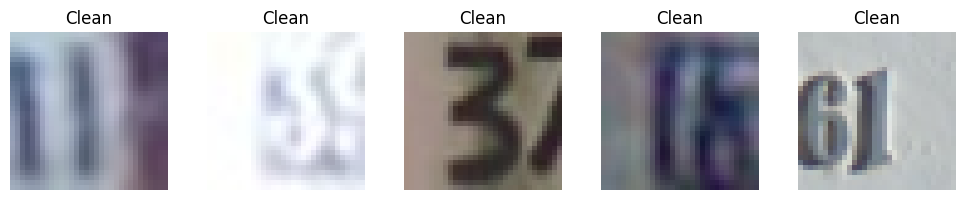

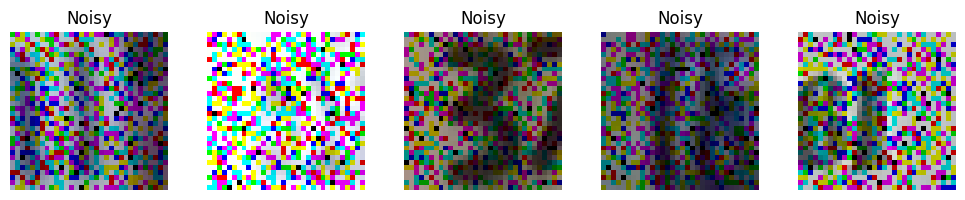

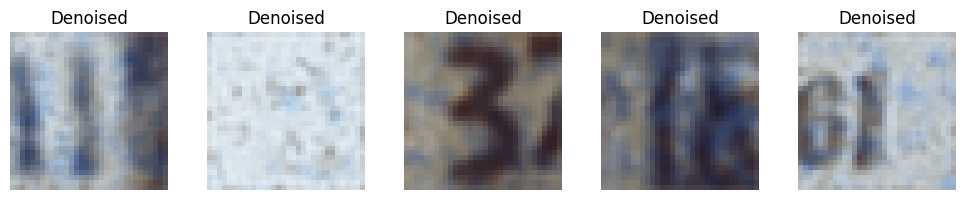

eval  100/100: 100%|████████████████████████████████████████████████| 24/24 [00:00<00:00, 78.81it/s]


In [119]:
learning_rate = 0.05
batch_size = 64
drop_rate = 0.3
num_samples = 1500
num_epochs = 100

# Setup code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, criterion, and optimizer
model = ImageDenoisingCNN().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss for image reconstruction
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders for first 5 classes (0-4)
first_five_classes = list(range(5))  # [0, 1, 2, 3, 4]
paired_trainloader_first_five = create_paired_dataloader(
  classes=first_five_classes, num_samples=num_samples, batch_size=batch_size, drop_prob=drop_rate, split='train'
)

paired_testloader_first_five = create_paired_dataloader(
  classes=first_five_classes, num_samples=num_samples, batch_size=batch_size, drop_prob=drop_rate, split='test'
)

# Train the model
print('Starting training...')
train_loss_epochs, test_loss_epochs = train(
  paired_trainloader_first_five, paired_testloader_first_five, model, num_epochs, criterion, optimizer, device
)

## **Task C (5 points): Plotting Training and Testing Losses Over Epochs**

To visualize the learning process of your model, plot the training and testing losses over each epoch. This allows you to evaluate model performance over time and helps identify potential issues, such as overfitting or underfitting.

Include this plot in your report.


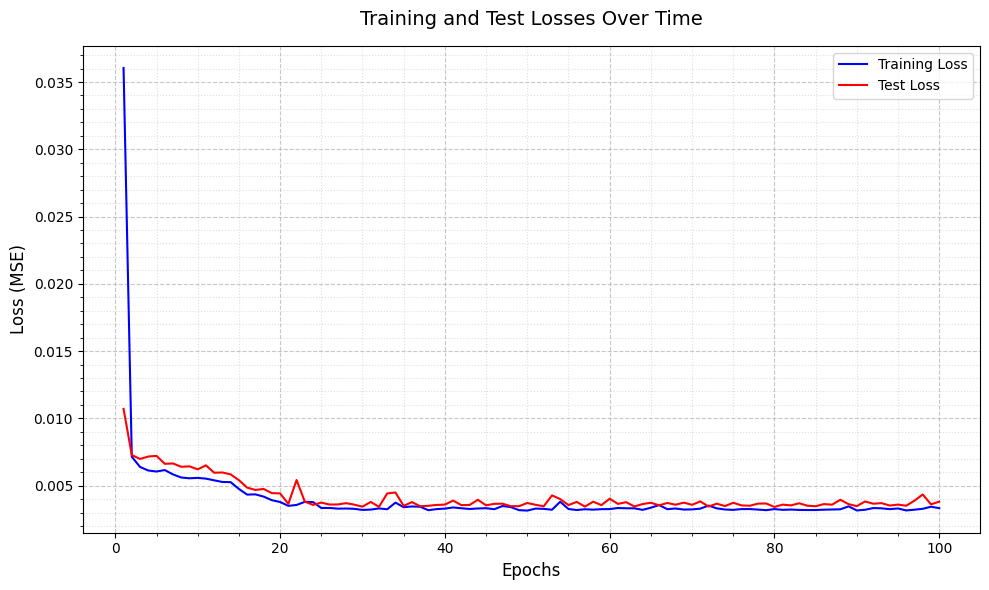

Final Training Loss: 0.003326
Final Test Loss: 0.003811


In [120]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and test losses
epochs = range(1, len(train_loss_epochs) + 1)
plt.plot(epochs, train_loss_epochs, label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, test_loss_epochs, label='Test Loss', color='red', linestyle='-')

# Customize the plot
plt.title('Training and Test Losses Over Time', fontsize=14, pad=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Add minor gridlines
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', alpha=0.4)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print final losses
print(f'Final Training Loss: {train_loss_epochs[-1]:.6f}')
print(f'Final Test Loss: {test_loss_epochs[-1]:.6f}')

## **Task D (10 points): Denoising Last 5 Classes, Reporting Loss, and Visualization**

Use your model to denoise images from classes 5-9 of the SVHN dataset. Report the test loss and visualize clean, noisy, and denoised images side by side. Include these results in your report.


In [126]:
# Load test data for classes 5-9 with 1,500 samples per class
last_five_classes = list(range(5, 10))  # [5, 6, 7, 8, 9]
paired_testloader_last_five = create_paired_dataloader(
  classes=last_five_classes, num_samples=num_samples, batch_size=batch_size, drop_prob=drop_rate, split='test'
)

print(f'Number of batches in paired_testloader_last_five: {len(paired_testloader_last_five)}')

# Evaluate model on the last 5 classes test set
model.eval()
test_loss = 0
total_batches = 0

# Store some examples for visualization
example_clean = None
example_noisy = None
example_denoised = None

with torch.no_grad():
  for batch_idx, (clean_images, noisy_images) in enumerate(paired_testloader_last_five):
    # Move images to device
    clean_images = clean_images.to(device)
    noisy_images = noisy_images.to(device)

    # Get model predictions
    denoised_images = model(noisy_images)

    # Calculate loss
    batch_loss = criterion(denoised_images, clean_images)
    test_loss += batch_loss.item()
    total_batches += 1

    # Store the first batch for visualization
    if batch_idx == 0:
      example_clean = clean_images
      example_noisy = noisy_images
      example_denoised = denoised_images

# Calculate average test loss
average_test_loss = test_loss / total_batches
print(f'Average Test Loss on classes 5-9: {average_test_loss:.6f}')

Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Number of batches in paired_testloader_last_five: 24
Average Test Loss on classes 5-9: 0.003754


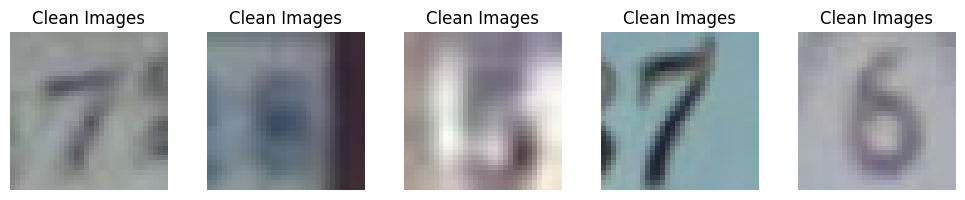

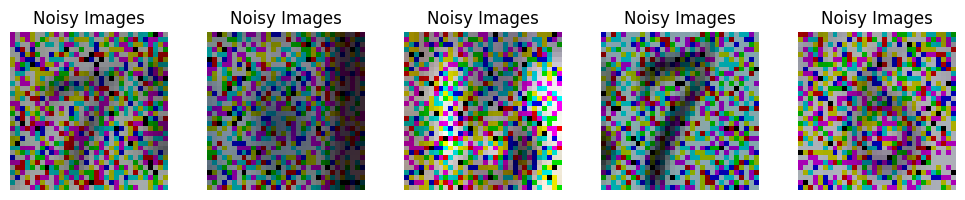

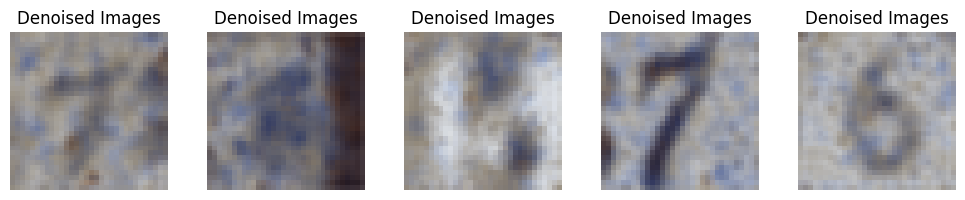

<Figure size 640x480 with 0 Axes>

Example images saved to denoising_examples_last_five.png


<Figure size 640x480 with 0 Axes>

In [128]:
# Move images to CPU for visualization and detach from computational graph
example_clean = example_clean.cpu().detach()
example_noisy = example_noisy.cpu().detach()
example_denoised = example_denoised.cpu().detach()


show_images_grid2(example_clean[:5], title='Clean Images', cols=5)
show_images_grid2(example_noisy[:5], title='Noisy Images', cols=5)
show_images_grid2(example_denoised[:5], title='Denoised Images', cols=5)

plt.tight_layout()
plt.show()

# Save example images if needed
save_path = 'denoising_examples_last_five.png'
plt.savefig(save_path)
print(f'Example images saved to {save_path}')

# <font color="red"> Task 3: Kaggle Competition (25 + 20 Bonus Points) </font>

For this task, you will participate in a Kaggle competition. Follow the steps below to maximize your performance and gain additional points:

1. **Account Setup**: Create a Kaggle account if you don’t already have one, and log in. Make sure to include your Kaggle username in both your report and code submission for verification purposes.

2. **Competition Details**: Access the competition at the link provided below and thoroughly read the description and requirements. Implement your solution in a separate file (not in this notebook) and aim to achieve the highest score possible on the leaderboard.

   - **[Kaggle Competition Link](<https://www.kaggle.com/t/37714339d17855022339af848ed11e96>)**

3. **Submission on A2L**: Ensure your A2L submission includes:
   - **Final Code**: Upload your final code file used for the Kaggle competition.
   - **Report** (`kaggle.pdf`): Provide a detailed report explaining your model and approach, along with the code used in your last Kaggle submission.
     - Start the report with your final accuracy score.
     - Clearly mention your Kaggle username for verification.
   - **Submission File** (`submission.csv`): Upload the final `submission.csv` file used in the competition as a record of your performance.

4. **Bonus Points**: Additional points will be awarded to the top-performing students on the competition leaderboard.
